In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
mpl.style.use('ggplot')

# Load data

## read csv file into pandas table

In [55]:
data = pd.read_csv('../fulldata/allflares.csv')

## create train and test set from original data

In [74]:
from sklearn.decomposition import PCA

def create_train_test_data(data, ts = 0.25, seed_no = 0, project_pca = False):
    X = data.iloc[:,:20].to_numpy()
    y = data.iloc[:,20].to_numpy()
    y = np.log10(np.exp(y))
    
    # split train and test set according to test size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=seed_no)
    
    # standardize each column of train and test separately
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    # create pca projection
    if project_pca:
        X_train = PCA(n_components=2).fit_transform(X_train)
        X_test = PCA(n_components=2).fit_transform(X_test)
    
    return X_train, y_train, X_test, y_test

X, y, X_test, y_test = create_train_test_data(data, ts = 0.25)

In [6]:
def create_solar_category_labels(y):
    return (y > -5).astype(int)

def create_labeled_train_data(X_train, y_train, X_test, y_test, thes0, thres1):
    train_index = np.logical_or(y_train > thres1, y_train < thres0) # index for train set
    val_index = np.logical_or(y_test > thres1, y_test < thres0) 
    
    train_int = y_train[train_index]
    train_lab = (train_int > thres1)
    
    val_int = y_test[val_index]
    val_lab = (val_int > thres1)
    
    return X_train[train_index,], train_int,  train_lab, X_test[val_index,], val_int, val_lab

In [91]:
thres0, thres1 = -5, -5.

X_train, train_int, train_lab, X_val, val_int, val_lab = create_labeled_train_data(X, y, 
                                                                                   X_test, y_test, thres0, thres1)

test_int, test_cat = y_test, create_solar_category_labels(y_test)

## visualize y

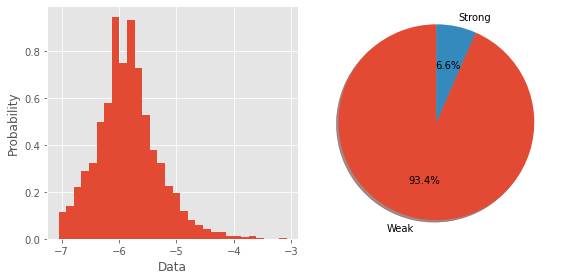

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax[0].hist(train_int, density = True, bins = 30)
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Data')

ax[1].pie([np.sum(train_lab == 0), np.sum(train_lab == 1)], labels=['Weak', 'Strong'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.tight_layout()

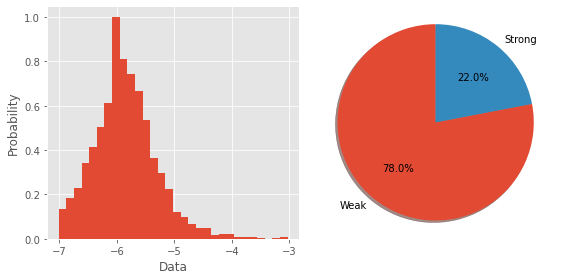

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax[0].hist(val_int, density = True, bins = 30)
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Data')

ax[1].pie([np.sum(val_lab == 0), np.sum(val_lab == 1)], labels=['Weak', 'Strong'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.tight_layout()

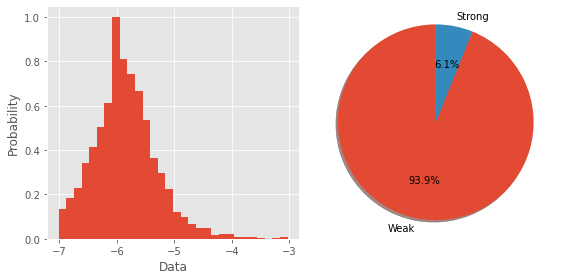

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax[0].hist(y_test, density = True, bins = 30)
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Data')

ax[1].pie([np.sum(test_cat == 0), np.sum(test_cat == 1)], labels=['Weak', 'Strong'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.tight_layout()

# Aside: Basic clustering structure of train set log intensity

In [11]:
from sklearn.cluster import KMeans

## cluster structure of joint density

In [96]:
Xy = np.zeros((X.shape[0], X.shape[1] + 1))
Xy[:,:X.shape[1]] = X
Xy[:,X.shape[1]] = y

In [97]:
kmeans = KMeans(n_clusters=2, random_state=200).fit(Xy)
kmeans.cluster_centers_[:,-1]

array([-5.56025058, -5.97060159])

## cluster structure of y

In [69]:
y_tilde = np.reshape(y, newshape = (len(y), 1))
kmeans = KMeans(n_clusters=2, random_state=200).fit(y_tilde)
kmeans.cluster_centers_

array([[-5.33219003],
       [-6.17380524]])

# Training procedure

## Step 1: manually create K clusters (labels)

## Step 2: Train classifier for train data with the labels in Step 1

### Logistic Regression Classifier

In [46]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, train_lab)
log_lpred_tprob = log_clf.predict_proba(X_train)

### Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, train_lab)
rf_clf_tprob = log_clf.predict_proba(X_train)

### GP Classifier

In [89]:
from sklearn.gaussian_process import GaussianProcessClassifier

gp_clf = GaussianProcessClassifier(kernel= Matern(length_scale=1.0, nu=1.5), random_state=0).fit(X_train, train_lab)

### Deep Learning Model

In [48]:
def ffn_classifier(X_train, train_lab, X_val, val_lab, n_epochs = 15):
    deep_learner = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(20, )),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2, activation='softmax')])
    
    deep_learner.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    res = deep_learner.fit(X_train, train_lab, validation_data=(X_val, val_lab), epochs=n_epochs)
    
    plt.plot(res.history['loss'], label='loss')
    plt.plot(res.history['val_loss'], label='val_loss')
    plt.legend()
    
    return deep_learner

Epoch 1/15
240/240 [==============================] - 1s 5ms/step - loss: 0.4682 - accuracy: 0.7955 - val_loss: 0.4503 - val_accuracy: 0.8037
Epoch 2/15
240/240 [==============================] - 1s 4ms/step - loss: 0.4413 - accuracy: 0.8046 - val_loss: 0.4503 - val_accuracy: 0.7982
Epoch 3/15
240/240 [==============================] - 1s 4ms/step - loss: 0.4392 - accuracy: 0.8081 - val_loss: 0.4418 - val_accuracy: 0.8076
Epoch 4/15
240/240 [==============================] - 1s 5ms/step - loss: 0.4274 - accuracy: 0.8079 - val_loss: 0.4383 - val_accuracy: 0.8115
Epoch 5/15
240/240 [==============================] - 1s 5ms/step - loss: 0.4294 - accuracy: 0.8094 - val_loss: 0.4288 - val_accuracy: 0.8135
Epoch 6/15
240/240 [==============================] - 1s 5ms/step - loss: 0.4222 - accuracy: 0.8126 - val_loss: 0.4375 - val_accuracy: 0.8076
Epoch 7/15
240/240 [==============================] - 1s 5ms/step - loss: 0.4214 - accuracy: 0.8144 - val_loss: 0.4540 - val_accuracy: 0.8080
Epoch 

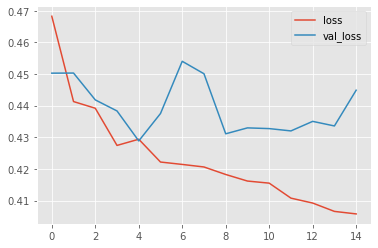

In [49]:
dl_clf = ffn_classifier(X_train, train_lab, X_val, val_lab)

### Ground Truth Classifier

In [50]:
class GroundTruthClassifier:
    def __init__(self, test_lab):
        self.lab = test_lab
        
    def predict(self, X):
        return self.lab

truth_clf = GroundTruthClassifier(test_cat)

### inspect classifier performance

In [51]:
def benchmark_classifier(clf, X_val, val_lab):
    pred = clf.predict(X_val)
    
    if len(pred.shape) > 1:
        pred = pred.argmax(axis=1)
    print(classification_report(val_lab, pred))

In [71]:
benchmark_classifier(log_clf, X_train, train_lab)
benchmark_classifier(log_clf, X_val, val_lab)
benchmark_classifier(log_clf, X_test, test_cat)

              precision    recall  f1-score   support

       False       0.82      0.96      0.88      5971
        True       0.65      0.25      0.36      1685

    accuracy                           0.80      7656
   macro avg       0.73      0.60      0.62      7656
weighted avg       0.78      0.80      0.77      7656

              precision    recall  f1-score   support

       False       0.82      0.96      0.89      1991
        True       0.64      0.27      0.38       561

    accuracy                           0.81      2552
   macro avg       0.73      0.61      0.63      2552
weighted avg       0.78      0.81      0.77      2552

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2396
           1       0.25      0.38      0.30       156

    accuracy                           0.89      2552
   macro avg       0.61      0.65      0.62      2552
weighted avg       0.91      0.89      0.90      2552



In [72]:
benchmark_classifier(rf_clf, X_train, train_lab)
benchmark_classifier(rf_clf, X_val, val_lab)
benchmark_classifier(rf_clf, X_test, test_cat)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5971
        True       1.00      1.00      1.00      1685

    accuracy                           1.00      7656
   macro avg       1.00      1.00      1.00      7656
weighted avg       1.00      1.00      1.00      7656

              precision    recall  f1-score   support

       False       0.84      0.96      0.89      1991
        True       0.70      0.34      0.45       561

    accuracy                           0.82      2552
   macro avg       0.77      0.65      0.67      2552
weighted avg       0.81      0.82      0.80      2552

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2396
           1       0.26      0.46      0.33       156

    accuracy                           0.89      2552
   macro avg       0.61      0.69      0.64      2552
weighted avg       0.92      0.89      0.90      2552



In [90]:
benchmark_classifier(gp_clf, X_train, train_lab)
benchmark_classifier(gp_clf, X_val, val_lab)
benchmark_classifier(gp_clf, X_test, test_cat)

              precision    recall  f1-score   support

       False       0.84      0.97      0.90      5971
        True       0.77      0.32      0.45      1685

    accuracy                           0.83      7656
   macro avg       0.80      0.65      0.68      7656
weighted avg       0.82      0.83      0.80      7656

              precision    recall  f1-score   support

       False       0.83      0.97      0.89      1991
        True       0.72      0.29      0.41       561

    accuracy                           0.82      2552
   macro avg       0.77      0.63      0.65      2552
weighted avg       0.80      0.82      0.79      2552

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2396
           1       0.29      0.41      0.34       156

    accuracy                           0.90      2552
   macro avg       0.62      0.67      0.64      2552
weighted avg       0.92      0.90      0.91      2552



In [73]:
benchmark_classifier(dl_clf, X_train, train_lab)
benchmark_classifier(dl_clf, X_val, val_lab)
benchmark_classifier(dl_clf, X_test, test_cat)

              precision    recall  f1-score   support

       False       0.85      0.95      0.89      5971
        True       0.68      0.38      0.49      1685

    accuracy                           0.83      7656
   macro avg       0.76      0.67      0.69      7656
weighted avg       0.81      0.83      0.81      7656

              precision    recall  f1-score   support

       False       0.83      0.94      0.88      1991
        True       0.61      0.32      0.42       561

    accuracy                           0.81      2552
   macro avg       0.72      0.63      0.65      2552
weighted avg       0.78      0.81      0.78      2552

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2396
           1       0.24      0.46      0.32       156

    accuracy                           0.88      2552
   macro avg       0.60      0.68      0.62      2552
weighted avg       0.92      0.88      0.90      2552



## Step 3:Train a local regressor for each cluster

In [74]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 

# one regressor for each cluster
def train_local_regressor(K, X, y, labs, RegModel, kwargs = {}):
    fitted = {} # covariates + intercept

    for k in range(K):
        index = (labs == k)
    
        Xk = X[index,]
        yk = y[index]
        
        regressor = RegModel(**kwargs)
        fitted[k] = regressor.fit(Xk, yk)
        
    return fitted

# one globla regressor with weighted sample by cluster
def train_weighted_regressor(X, y, fitted_clf, RegModel, kwargs = {}):
    wprobs = fitted_clf.predict_proba(X)[:,1]  # weighted probabilities
    
    regressor = RegModel(**kwargs)    
    fitted = regressor.fit(X, y, wprobs)
        
    return fitted

# predict log intensity
def predict_log_intensity(X_test, fitted_clf, fitted_reg, weighted_regressor = False):
    # predict cluster assignment
    lpred = fitted_clf.predict(X_test)
    if len(lpred.shape) > 1: lpred = lpred.argmax(axis=1)
    
    ypred = np.zeros(len(lpred))
    
    # apply local regressor or weighted global regressor to predict log intensity
    if not weighted_regressor:
        for k in np.unique(lpred):
            index = (lpred == k)
            ypred[index] = fitted_reg[k].predict(X_test[index,])
    else:
         ypred = fitted_reg.predict(X_test)
        
    return ypred

# predict log intensity with local regressors given all labels are known
def predict_log_intensity_given_true_labs(X_test, test_lab, fitted_reg, weighted_regressor = False):    
    ypred = np.zeros(len(test_lab))
    
    # apply local regressor or weighted global regressor to predict log intensity
    if not weighted_regressor:
        for k in np.unique(test_lab):
            index = (test_lab == k)
            ypred[index] = fitted_reg[k].predict(X_test[index,])
    else:
        ypred = fitted_reg.predict(X_test)
    
    return ypred

## Vanilla: Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression

fitted_lreg = train_local_regressor(2, X_train, train_int, train_lab, LinearRegression) # local regressors
fitted_wlr = train_weighted_regressor(X_train, train_int, log_clf, LinearRegression) # weighted regressors

## Advanced Regressors

### local regressors

In [76]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 

fitted_svr = train_local_regressor(2, X_train, train_int, train_lab, SVR, {'kernel': 'poly'})
fitted_rfr = train_local_regressor(2, X_train, train_int, train_lab, RandomForestRegressor, {'n_estimators':100})

In [77]:
from sklearn.kernel_ridge import KernelRidge

fitted_kernel = train_local_regressor(2, X_train, train_int, train_lab, KernelRidge, {'kernel':'poly'})

In [87]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

fitted_gpr = train_local_regressor(2, X_train, train_int, train_lab, GaussianProcessRegressor, 
                                   {'kernel': Matern(length_scale=1.0, nu=1.5), 'random_state':0})

/Users/vietdo/opt/anaconda2/envs/mlpy36/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/vietdo/opt/anaconda2/envs/mlpy36/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


### weighted regressors

In [57]:
fitted_wrfr = train_weighted_regressor(X_train, train_int, rf_clf, RandomForestRegressor, {'n_estimators':100})

# Prediction

### plot out the result

In [78]:
def report_rmse(y_true, y_pred, true_lab):
    print('RMSE = ', np.sqrt(np.mean(np.square(y_true - y_pred))))
    
    cat = np.unique(true_lab)
    for c in cat:
        index = (true_lab == c)
            
        print('Class ' + str(c) + ' RMSE ',  np.sqrt(np.mean(np.square(y_true[index] - y_pred[index]))))

def report_mse(y_true, y_pred, true_lab):
    print('MSE = ',np.mean(np.square(y_true - y_pred)))
    
    cat = np.unique(true_lab)
    for c in cat:
        index = (true_lab == c)
        print('Class ' + str(c) + ' MSE ', np.mean(np.square(y_true[index] - y_pred[index])))

def run_forecast_performance_y(y_test, y_pred, true_lab, rsize = 100, col = 'red'):
    report_rmse(y_test, y_pred, true_lab)
        
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    ax[0].plot(range(rsize), y_test[:rsize], color = 'gray')  
    ax[0].plot(range(rsize), y_pred[:rsize], color= col)  
    

    ax[1].scatter(y_test, y_pred, color = col)
    ax[1].set_xlabel("X[,0]")
    ax[1].set_ylabel("X[,1]")
    ax[1].set_xlim((-7.5, -3))
    ax[1].set_ylim((-7.5, -3))
    
    fig.tight_layout()

### Basline rmse

In [58]:
CAT_THRES = -5

In [79]:
from numpy.linalg import inv

# baseline
X_design = np.ones((X_train.shape[0], X_train.shape[1] + 1))
X_tdesg = np.ones((X_test.shape[0], X_test.shape[1] + 1))

X_design[:,1:] = X_train
X_tdesg[:,1:] = X_test

beta_hat = inv(X_design.T.dot(X_design)).dot(X_design.T).dot(train_int)

RMSE =  0.45364989308396897
Class False RMSE  0.35679225263449
Class True RMSE  0.6956749239928778


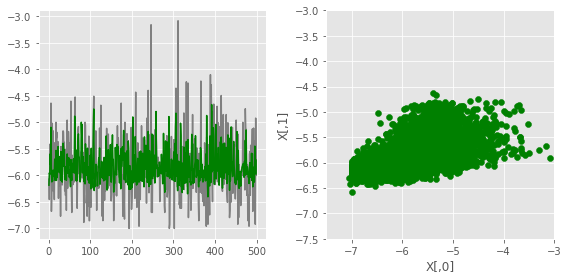

In [80]:
y_hat = X_design.dot(beta_hat)
run_forecast_performance_y(train_int, y_hat, train_lab, 500, 'green') 

RMSE =  0.45391216704783266
Class 0 RMSE  0.38123040655842905
Class 1 RMSE  1.066920969287042


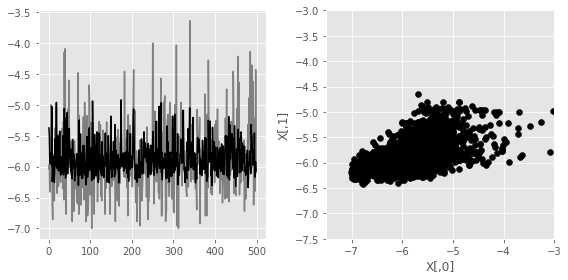

In [81]:
y_hat = X_tdesg.dot(beta_hat)
run_forecast_performance_y(y_test, y_hat, test_cat, 500, 'black') 

## SPECIAL CASE: Regressors with perfect Classifier Prediction Performance Analysis

RMSE =  0.3233225720371667
Class False RMSE  0.31207023444276943
Class True RMSE  0.36037916845660806
RMSE =  0.40788535706104356
Class 0 RMSE  0.3888251448716908
Class 1 RMSE  0.6321421735707161


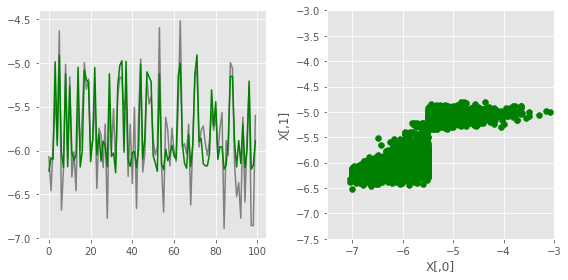

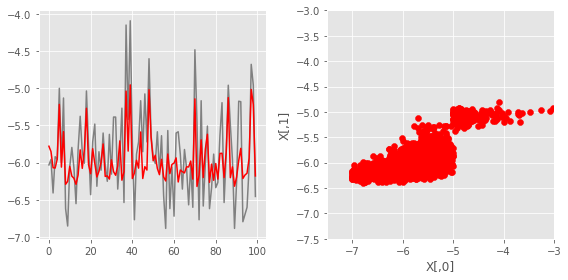

In [82]:
# Train set
y_pred = predict_log_intensity_given_true_labs(X_train, train_lab, fitted_lreg)
run_forecast_performance_y(train_int, y_pred, train_lab, 100, 'green')

# Test Set
y_pred = predict_log_intensity_given_true_labs(X_test, test_cat, fitted_lreg)
run_forecast_performance_y(y_test, y_pred, test_cat, 100, 'red')

RMSE =  0.2831405816803058
Class False RMSE  0.2623508974113449
Class True RMSE  0.3469226894718943
RMSE =  0.40342725679633484
Class 0 RMSE  0.3775889240539667
Class 1 RMSE  0.6875318534038913


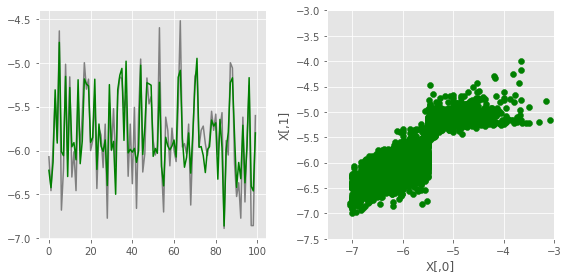

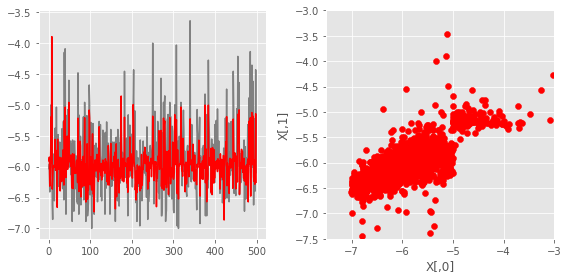

In [83]:
# Train set
y_pred = predict_log_intensity_given_true_labs(X_train, train_lab, fitted_svr)
run_forecast_performance_y(train_int, y_pred, train_lab, 100, 'green')

y_pred = predict_log_intensity_given_true_labs(X_test, test_cat, fitted_svr)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'red') 

RMSE =  0.26386520963250837
Class False RMSE  0.24489523167116142
Class True RMSE  0.32221878445434904
RMSE =  0.36693955968381087
Class 0 RMSE  0.3452083956885672
Class 1 RMSE  0.610194327563049


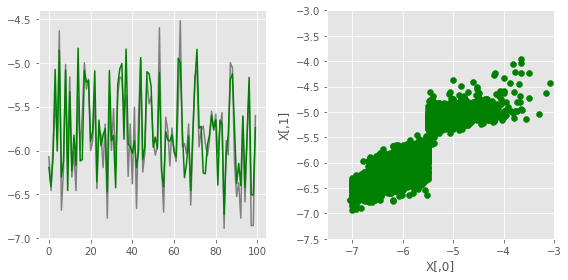

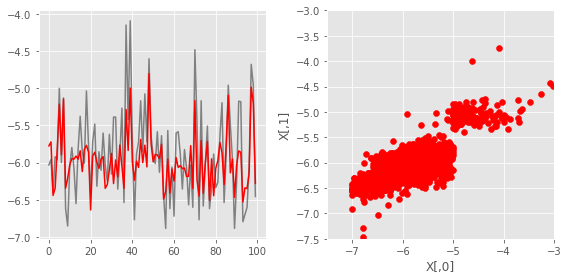

In [84]:
# Train Kernel Regression
y_pred = predict_log_intensity_given_true_labs(X_train, train_lab, fitted_kernel)
run_forecast_performance_y(train_int, y_pred, train_lab, 100, 'green')

# TEst Kernel Regression
y_pred = predict_log_intensity_given_true_labs(X_test, test_cat, fitted_kernel)
run_forecast_performance_y(y_test, y_pred, test_cat, 100, 'red')

RMSE =  0.009251056702796995
Class False RMSE  0.008962787951751004
Class True RMSE  0.010207240810572692
RMSE =  1.0361208963953945
Class 0 RMSE  1.035088199595248
Class 1 RMSE  1.0518546945381169


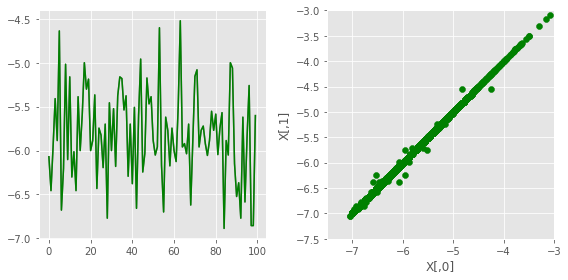

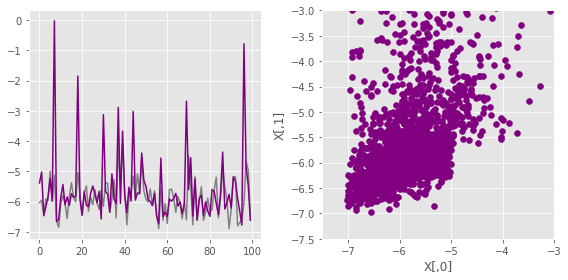

In [88]:
y_pred = predict_log_intensity_given_true_labs(X_train, train_lab, fitted_gpr)
run_forecast_performance_y(train_int, y_pred, train_lab, 100, 'green')

# GP Regression
y_pred = predict_log_intensity_given_true_labs(X_test, test_cat, fitted_gpr)
run_forecast_performance_y(y_test, y_pred, test_cat, 100, 'purple')

RMSE =  0.09833751024546952
Class False RMSE  0.0836326279869325
Class True RMSE  0.1383924132728624
RMSE =  0.3560499598127588
Class 0 RMSE  0.33609852925204686
Class 1 RMSE  0.5821246130422423


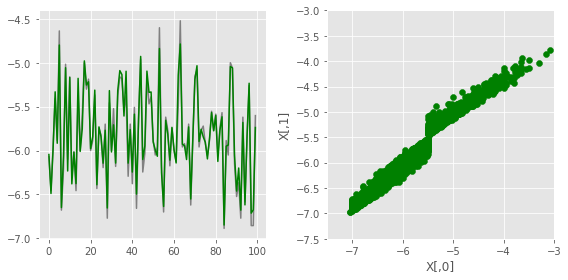

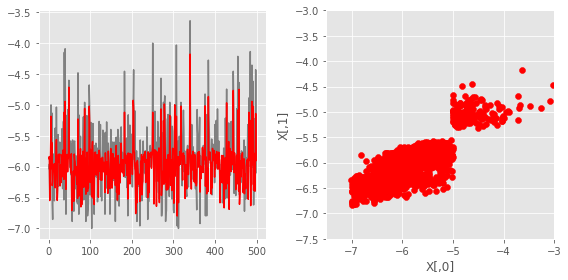

In [86]:
# Local Random Forest regression
y_pred = predict_log_intensity_given_true_labs(X_train, train_lab, fitted_rfr)
run_forecast_performance_y(train_int, y_pred, train_lab, 100, 'green')


y_pred = predict_log_intensity_given_true_labs(X_test, test_cat, fitted_rfr)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'red') 

## Trained Classifiered + Trained Regressor Prediction Performance

### Local Linear Regression

RMSE =  0.4895156685366741
Class 0 RMSE  0.4074697021299055
Class 1 RMSE  1.1704505260338987


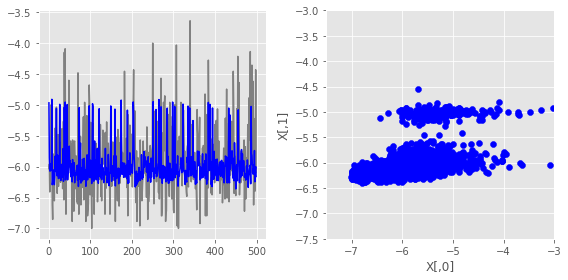

In [63]:
y_pred = predict_log_intensity(X_test, log_clf, fitted_lreg)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'blue') 

RMSE =  0.4724923630730484
Class 0 RMSE  0.3977792560397483
Class 1 RMSE  1.1053959677221092


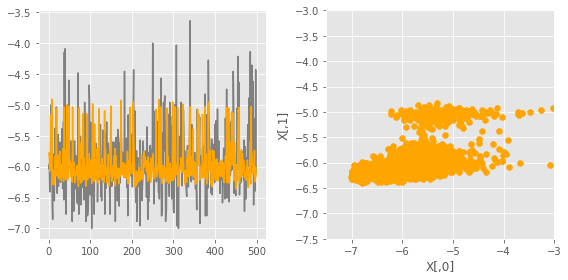

In [64]:
y_pred = predict_log_intensity(X_test, rf_clf, fitted_lreg)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'orange') 

### Local SVM Regressor

RMSE =  0.45903448333652613
Class 0 RMSE  0.37282811600919835
Class 1 RMSE  1.1454838127880906


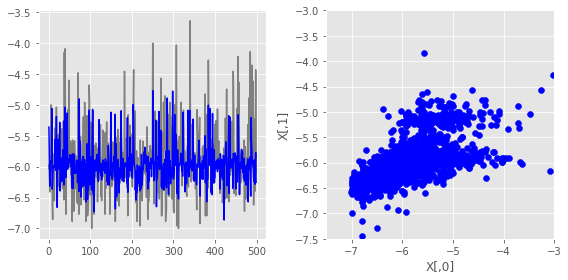

In [65]:
y_pred = predict_log_intensity(X_test, log_clf, fitted_svr)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'blue') 

RMSE =  0.45316299364764223
Class 0 RMSE  0.3724357637810629
Class 1 RMSE  1.108605538434903


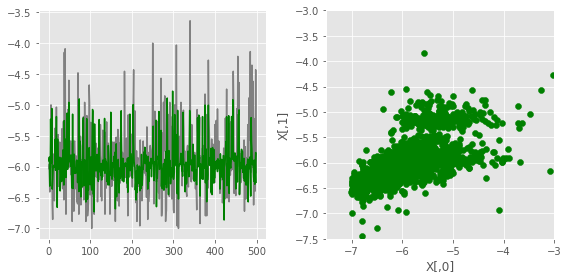

In [68]:
y_pred = predict_log_intensity(X_test, rf_clf, fitted_svr)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'green') 

### Local Random Forest Regressor

RMSE =  0.4392753532577523
Class 0 RMSE  0.3533060270559788
Class 1 RMSE  1.1133228763293195


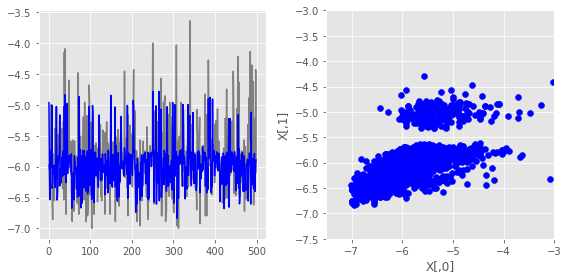

In [69]:
y_pred = predict_log_intensity(X_test, log_clf, fitted_rfr)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'blue') 

RMSE =  0.42844982648110685
Class 0 RMSE  0.34762363253537115
Class 1 RMSE  1.0709774134358936


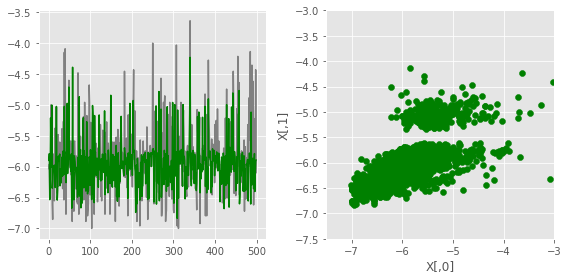

In [70]:
y_pred = predict_log_intensity(X_test, rf_clf, fitted_rfr)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'green') 

## Weighted Regressor

### Weighted LR

#### Logistic Classifier

RMSE =  0.45873488403544
Class 0 RMSE  0.38714820734882377
Class 1 RMSE  1.0679346437146582


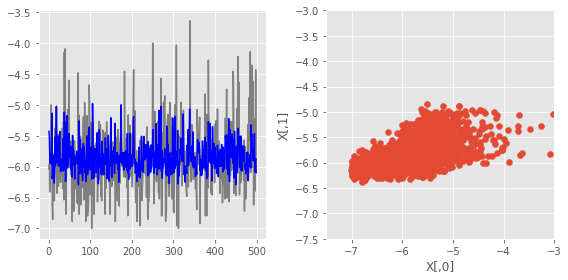

In [396]:
y_pred = predict_log_intensity(X_test, log_clf, fitted_wlr, True)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'blue') 

#### DL Classifier

RMSE =  0.45873488403544
Class 0 RMSE  0.38714820734882377
Class 1 RMSE  1.0679346437146582


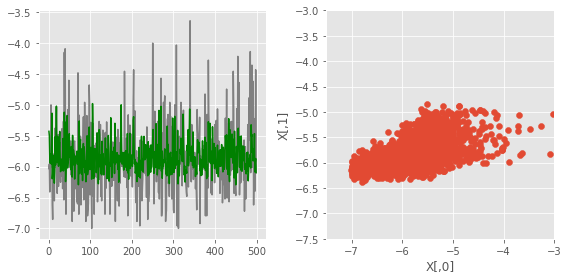

In [397]:
y_pred = predict_log_intensity(X_test, dl_clf, fitted_wlr, True)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'green') 

#### RF Classifier

RMSE =  0.45873488403544
Class 0 RMSE  0.38714820734882377
Class 1 RMSE  1.0679346437146582


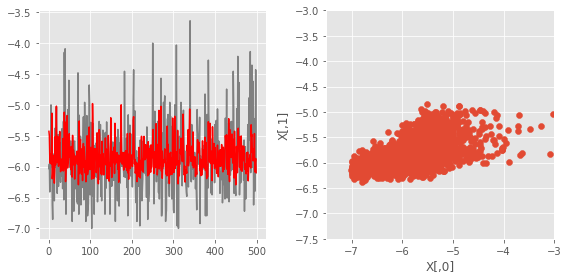

In [398]:
y_pred = predict_log_intensity(X_test, rf_clf, fitted_wlr, True)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'red') 

### Weighted RF Regressor

RMSE =  0.3924376784032227
Class 0 RMSE  0.31606447090450673
Class 1 RMSE  0.9925171876254689


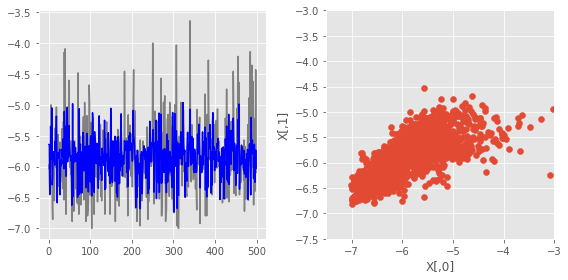

In [416]:
y_pred = predict_log_intensity(X_test, log_clf, fitted_wrfr, True)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'blue') 

RMSE =  0.3924376784032227
Class 0 RMSE  0.31606447090450673
Class 1 RMSE  0.9925171876254689


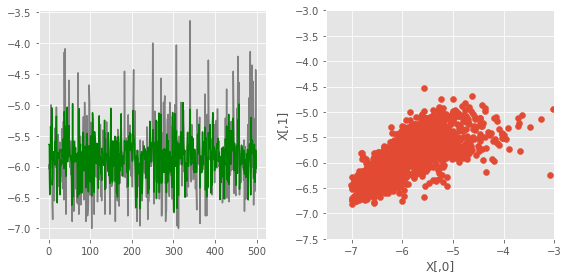

In [415]:
y_pred = predict_log_intensity(X_test, dl_clf, fitted_wrfr, True)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'green') 

RMSE =  0.3924376784032227
Class 0 RMSE  0.31606447090450673
Class 1 RMSE  0.9925171876254689


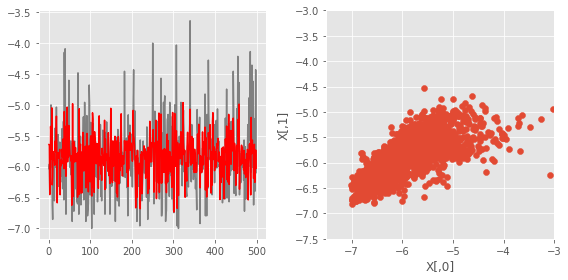

In [414]:
y_pred = predict_log_intensity(X_test, rf_clf, fitted_wrfr, True)
run_forecast_performance_y(y_test, y_pred, test_cat, 500, 'red') 

# PCA

In [75]:
pca = PCA(n_components=3)

pca_train = pca.fit_transform(X)
pca_test = pca.fit_transform(X_test)

In [77]:
X.std(axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

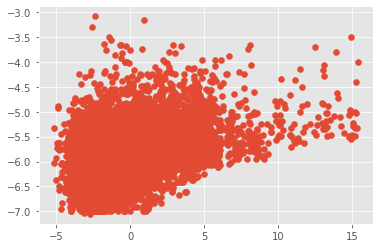

In [78]:
size = pca_train.shape[0]

plt.scatter(pca_train[:size,0], y[:size])

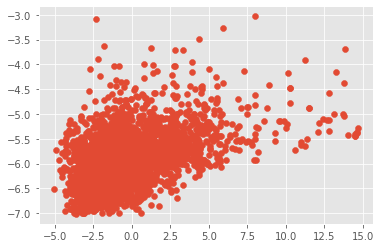

In [79]:
size = pca_train.shape[0]

plt.scatter(pca_test[:size,0], y_test[:size])

In [119]:
thres = 5.5
index1 = pca_train[:,0] > thres
index2 = pca_train[:,0] <= thres

In [96]:
from sklearn.linear_model import LinearRegression

lr1 = LinearRegression().fit(X[index1,:], y[index1])
lr2 = LinearRegression().fit(X[index2,:], y[index2])

In [113]:
from sklearn.ensemble import RandomForestRegressor

rf1 = RandomForestRegressor(n_estimators = 100).fit(X[index1,:], y[index1])
rf2 = RandomForestRegressor(n_estimators = 100).fit(X[index2,:], y[index2])

In [97]:
i1 = pca_test[:,0] > thres
i2 = pca_test[:,0] <= thres

In [114]:
y_pred = np.zeros(len(y_test))
y_pred[i1] = lr1.predict(X_test[i1,:])
y_pred[i2] = lr2.predict(X_test[i2,:])

In [116]:
y_pred = np.zeros(len(y_test))
y_pred[i1] = rf1.predict(X_test[i1,:])
y_pred[i2] = rf2.predict(X_test[i2,:])

In [118]:
np.sqrt(np.mean(np.square((y_pred - y_test))))

0.3947375085918886

In [100]:
y_test

array([-6.03151705, -5.95860731, -6.40893539, ..., -5.58502665,
       -5.49485002, -6.11350927])

In [101]:
lr = LinearRegression().fit(X,y)
y_pred = lr.predict(X_test)
np.sqrt(np.mean(np.square((y_pred - y_test))))

0.45391216704783416

In [122]:
rf = RandomForestRegressor(n_estimators=100).fit(X, y)
y_pred = rf.predict(X_test)
np.sqrt(np.mean(np.square((y_pred - y_test))))

0.39337568654990623